In [12]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_excel('jobs.xlsx')


In [13]:
df.dtypes

time_of_post             datetime64[ns]
latitude                        float64
longitude                       float64
category                          int64
number_of_tradies                 int64
estimated_size                   object
number_of_impressions           float64
accepted                          int64
dtype: object

In [14]:
len(df)

9999

In [15]:
df.isna().sum()

time_of_post               0
latitude                   0
longitude                  0
category                   0
number_of_tradies          0
estimated_size             0
number_of_impressions    110
accepted                   0
dtype: int64

In [16]:
df = df.dropna()

In [17]:
len(df)

9889

In [19]:
df = df[df['number_of_impressions'] >= 0]

In [20]:


df['hour'] = df['time_of_post'].dt.hour

# Feature engineering: Region from lat/lon
def get_region(lat, lon):
    if lat > -20 and lon > 120 and lon < 125:  # Broome approx
        return 'WA'
    elif lat > -35 and lat < -32 and lon > 150:  # Sydney approx
        return 'NSW'
    elif lat > -39 and lat < -36 and lon > 144 and lon < 146:  # Melbourne approx
        return 'VIC'
    else:
        return 'Other'

df['region'] = df.apply(lambda row: get_region(row['latitude'], row['longitude']), axis=1)

# # Handle missing/negatives in impressions
# df['number_of_impressions'] = df['number_of_impressions'].replace('', np.nan)
# df['number_of_impressions'].fillna(df['number_of_impressions'].median(), inplace=True)
# df['number_of_impressions'] = df['number_of_impressions'].abs()
# df = df[df['number_of_impressions'] >= 0]

# Encode categoricals
le_size = LabelEncoder()
df['estimated_size_encoded'] = le_size.fit_transform(df['estimated_size'])
le_region = LabelEncoder()
df['region_encoded'] = le_region.fit_transform(df['region'])

# Select features (exclude lat/lon if redundant with region)
features = ['hour', 'number_of_tradies', 'number_of_impressions', 'estimated_size_encoded', 'region_encoded', 'category']
X = df[features]
y = df['accepted']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Data prepared. X shape:", X.shape, "Imbalance:", y.value_counts(normalize=True))

Data prepared. X shape: (9760, 6) Imbalance: accepted
0    0.735861
1    0.264139
Name: proportion, dtype: float64


In [34]:
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2

# --- Fix chi2 (scale to non-negative) ---
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

selector = SelectKBest(score_func=chi2, k=4)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

chi_scores = pd.DataFrame({
    'Feature': features,
    'Chi2 Score': selector.scores_
}).sort_values('Chi2 Score', ascending=False)
print(chi_scores)

# --- Permutation importance ---
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

perm = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
perm_importance = pd.DataFrame({
    'Feature': features,
    'Importance': perm.importances_mean
}).sort_values('Importance', ascending=False)
print(perm_importance)


/Users/dev/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/dev/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/dev/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


                  Feature  Chi2 Score
3  estimated_size_encoded  212.837542
1       number_of_tradies  102.785140
0                    hour   72.018092
4          region_encoded    4.959017
5                category    0.667244
2   number_of_impressions    0.000646
                  Feature  Importance
0                    hour    0.073873
3  estimated_size_encoded    0.031660
2   number_of_impressions    0.008811
1       number_of_tradies    0.008453
4          region_encoded   -0.001895
5                category   -0.015676


In [28]:
import pandas as pd

# Assuming df is your preprocessed DataFrame with features and target
correlation_matrix = df[['hour', 'number_of_tradies','region_encoded', 'number_of_impressions', 'estimated_size_encoded', 'category','accepted']].corr()
print(correlation_matrix)

                            hour  number_of_tradies  region_encoded  \
hour                    1.000000          -0.009790        0.000172   
number_of_tradies      -0.009790           1.000000        0.198672   
region_encoded          0.000172           0.198672        1.000000   
number_of_impressions   0.003855           0.008589       -0.010727   
estimated_size_encoded  0.007238          -0.016083       -0.001597   
category                0.002345          -0.077495       -0.011907   
accepted                0.295683           0.232365        0.047408   

                        number_of_impressions  estimated_size_encoded  \
hour                                 0.003855                0.007238   
number_of_tradies                    0.008589               -0.016083   
region_encoded                      -0.010727               -0.001597   
number_of_impressions                1.000000               -0.013957   
estimated_size_encoded              -0.013957                1.000

In [30]:
correlation_matrix['accepted']

hour                      0.295683
number_of_tradies         0.232365
region_encoded            0.047408
number_of_impressions     0.001236
estimated_size_encoded   -0.229945
category                 -0.027716
accepted                  1.000000
Name: accepted, dtype: float64

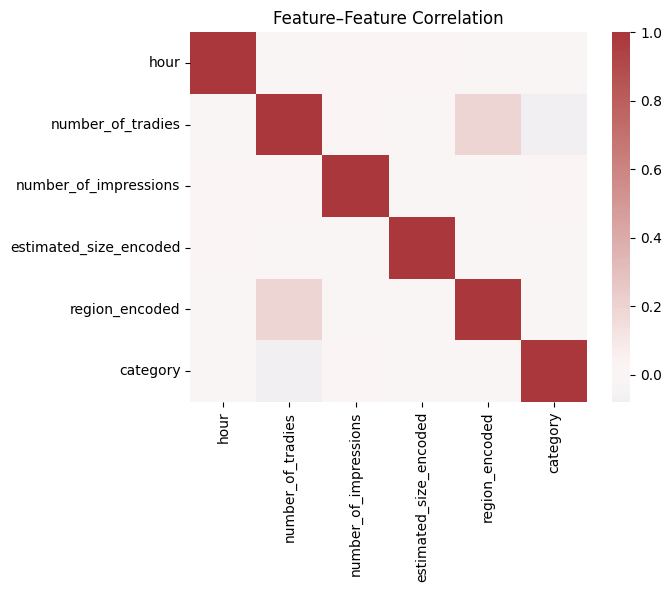

In [33]:
# Correlation among features only
feat_corr = X_train.corr(numeric_only=True)
sns.heatmap(feat_corr, cmap="vlag", center=0)
plt.title("Feature–Feature Correlation")
plt.show()


In [35]:
# =========================
# Optimized LR & RF Pipelines
# =========================
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (roc_auc_score, average_precision_score, f1_score,
                             precision_recall_curve, roc_curve, confusion_matrix,
                             classification_report)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

rng = np.random.RandomState(42)

# -------------------------
# Use your existing df & split
# (Assumes you've created df, features, y as per your snippet)
# -------------------------
# features = ['hour','number_of_tradies','number_of_impressions',
#             'estimated_size_encoded','region_encoded','category']
# X = df[features]
# y = df['accepted']
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )

print("X train/test:", X_train.shape, X_test.shape)
print("Class balance (train):")
print(y_train.value_counts(normalize=True).rename('prop'))

# -------------------------
# Column typing
# -------------------------
# Treat these as categorical even if they’re encoded as ints:
force_categoricals = {'estimated_size_encoded', 'region_encoded', 'category'}

cat_cols = [c for c in X_train.columns
            if (c in force_categoricals) or (X_train[c].dtype == 'object') or (str(X_train[c].dtype) == 'category')]
num_cols = [c for c in X_train.columns if c not in cat_cols]

print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

# -------------------------
# Preprocessors
# -------------------------
# For LR: scale numerics, one-hot cats
preprocess_lr = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('impute', SimpleImputer(strategy='median')),
            ('scale', StandardScaler())
        ]), num_cols),
        ('cat', Pipeline([
            ('impute', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
        ]), cat_cols),
    ],
    remainder='drop'
)

# For RF: no scaling needed; still one-hot cats (safe & often better for LR comparability)
preprocess_rf = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), num_cols),
        ('cat', Pipeline([
            ('impute', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
        ]), cat_cols),
    ],
    remainder='drop'
)

# -------------------------
# Models
# -------------------------
log_reg = LogisticRegression(
    solver='saga',            # handles L1/L2/elasticnet + sparse
    penalty='l2',
    max_iter=5000,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

rf = RandomForestClassifier(
    n_estimators=600,
    max_depth=None,
    max_features='sqrt',
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

# -------------------------
# Pipelines
# -------------------------
pipe_lr = Pipeline(steps=[('prep', preprocess_lr), ('clf', log_reg)])
pipe_rf = Pipeline(steps=[('prep', preprocess_rf), ('clf', rf)])

# -------------------------
# CV search spaces
# (Randomized for speed; good defaults already set)
# -------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid_lr = {
    'clf__C': np.logspace(-3, 2, 20),
    # Toggle penalties quickly if you want sparsity:
    # 'clf__penalty': ['l1', 'l2'],
    # 'clf__l1_ratio': [0.0, 0.5, 1.0],   # only used if penalty='elasticnet'
}

param_grid_rf = {
    'clf__n_estimators': rng.randint(300, 1000, size=20),
    'clf__max_depth': [None] + list(rng.randint(3, 30, size=15)),
    'clf__min_samples_split': rng.randint(2, 10, size=10),
    'clf__min_samples_leaf': rng.randint(1, 8, size=10),
    'clf__max_features': ['sqrt', 'log2', None]
}

search_lr = RandomizedSearchCV(
    pipe_lr,
    param_distributions=param_grid_lr,
    n_iter=30,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=0
)

search_rf = RandomizedSearchCV(
    pipe_rf,
    param_distributions=param_grid_rf,
    n_iter=40,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=0
)

# -------------------------
# Fit searches
# -------------------------
search_lr.fit(X_train, y_train)
search_rf.fit(X_train, y_train)

print("Best LR params:", search_lr.best_params_, "AUC:", search_lr.best_score_)
print("Best RF params:", search_rf.best_params_, "AUC:", search_rf.best_score_)

best_lr = search_lr.best_estimator_
best_rf = search_rf.best_estimator_

# -------------------------
# Evaluate helper
# -------------------------
def evaluate(name, model, X_tr, y_tr, X_te, y_te, threshold=None):
    proba_tr = model.predict_proba(X_tr)[:, 1]
    proba_te = model.predict_proba(X_te)[:, 1]

    auc_tr = roc_auc_score(y_tr, proba_tr)
    auc_te = roc_auc_score(y_te, proba_te)
    ap_te  = average_precision_score(y_te, proba_te)

    # pick threshold by Youden's J (maximize tpr - fpr) unless provided
    if threshold is None:
        fpr, tpr, thr = roc_curve(y_te, proba_te)
        j = tpr - fpr
        threshold = thr[np.argmax(j)]

    preds_te = (proba_te >= threshold).astype(int)
    cm = confusion_matrix(y_te, preds_te)

    print(f"\n=== {name} ===")
    print(f"AUC (train): {auc_tr:0.4f} | AUC (test): {auc_te:0.4f} | PR-AUC (test): {ap_te:0.4f}")
    print(f"Threshold: {threshold:0.4f}")
    print("Confusion matrix [[TN, FP],[FN, TP]]:\n", cm)
    print("Classification report:\n", classification_report(y_te, preds_te, digits=3))
    return threshold

thr_lr = evaluate("Logistic Regression", best_lr, X_train, y_train, X_test, y_test)
thr_rf = evaluate("Random Forest", best_rf, X_train, y_train, X_test, y_test)

# -------------------------
# Interpretability
# -------------------------

# LR: feature names (after one-hot) and coefficients
def get_lr_coefs(fitted_lr_pipeline):
    prep = fitted_lr_pipeline.named_steps['prep']
    clf  = fitted_lr_pipeline.named_steps['clf']

    # Build feature name list from ColumnTransformer
    ohe = prep.named_transformers_['cat'].named_steps['onehot']
    cat_out = list(ohe.get_feature_names_out(cat_cols)) if len(cat_cols) else []
    num_out = num_cols  # scaler keeps same names
    feat_names = list(num_out) + list(cat_out)

    coefs = pd.Series(clf.coef_.ravel(), index=feat_names).sort_values(key=np.abs, ascending=False)
    return coefs

lr_coefs = get_lr_coefs(best_lr)
print("\nTop LR coefficients (abs):\n", lr_coefs.head(15))

# RF: permutation importance (model-agnostic, test set)
perm = permutation_importance(best_rf, X_test, y_test, n_repeats=10, n_jobs=-1, random_state=42)
perm_df = pd.DataFrame({
    'Feature': X_test.columns,
    'PermImportance': perm.importances_mean,
    'PermStd': perm.importances_std
}).sort_values('PermImportance', ascending=False)
print("\nRF Permutation Importance (test):\n", perm_df)

# OPTIONAL: quick threshold tuning by business metric (e.g., maximize F1)
def best_f1_threshold(proba, y_true):
    p, r, t = precision_recall_curve(y_true, proba)
    f1s = 2*p*r/(p+r+1e-12)
    ix = np.nanargmax(f1s)
    return t[max(ix-1,0)], f1s[ix]

thr_opt, f1_opt = best_f1_threshold(best_rf.predict_proba(X_test)[:,1], y_test)
print(f"\nBest F1 threshold (RF): {thr_opt:0.4f} | F1={f1_opt:0.4f}")


X train/test: (7808, 6) (1952, 6)
Class balance (train):
accepted
0    0.735912
1    0.264088
Name: prop, dtype: float64
Numeric cols: ['hour', 'number_of_tradies', 'number_of_impressions']
Categorical cols: ['estimated_size_encoded', 'region_encoded', 'category']


/Users/dev/Library/Python/3.9/lib/python/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 20 is smaller than n_iter=30. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/dev/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/dev/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/dev/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/dev/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/dev/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/U

Best LR params: {'clf__C': np.float64(0.011288378916846888)} AUC: 0.7881980183971784
Best RF params: {'clf__n_estimators': np.int64(672), 'clf__min_samples_split': np.int64(5), 'clf__min_samples_leaf': np.int64(2), 'clf__max_features': None, 'clf__max_depth': np.int64(3)} AUC: 0.8160529713118345

=== Logistic Regression ===
AUC (train): 0.7901 | AUC (test): 0.7815 | PR-AUC (test): 0.5572
Threshold: 0.4718
Confusion matrix [[TN, FP],[FN, TP]]:
 [[1019  417]
 [ 129  387]]
Classification report:
               precision    recall  f1-score   support

           0      0.888     0.710     0.789      1436
           1      0.481     0.750     0.586       516

    accuracy                          0.720      1952
   macro avg      0.684     0.730     0.688      1952
weighted avg      0.780     0.720     0.735      1952


=== Random Forest ===
AUC (train): 0.8174 | AUC (test): 0.8023 | PR-AUC (test): 0.5759
Threshold: 0.4868
Confusion matrix [[TN, FP],[FN, TP]]:
 [[1020  416]
 [ 124  392]]
Cl

/Users/dev/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/dev/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/dev/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/dev/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/dev/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/dev/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b



RF Permutation Importance (test):
                   Feature  PermImportance   PermStd
0                    hour        0.133607  0.008964
3  estimated_size_encoded        0.030123  0.005008
1       number_of_tradies        0.022234  0.003529
2   number_of_impressions        0.000000  0.000000
4          region_encoded        0.000000  0.000000
5                category        0.000000  0.000000

Best F1 threshold (RF): 0.4864 | F1=0.5921
